# Библиотеки

In [ ]:
import numpy as np
import unicodedata
import re
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import random
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from nltk.translate.bleu_score import corpus_bleu
from gensim.utils import tokenize
from gensim.similarities import WmdSimilarity
import gensim.downloader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Данные

Anki (https://www.manythings.org/anki/) - англоориентированная коллекция параллельных текстов, взятых из проекта Tatoeba. Включает 86 пар языков.

## Загрузка

Ссылка на архив - https://www.manythings.org/anki/rus-eng.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/rus.txt'

lines = open(path, encoding='UTF-8').read().strip().split('\n')

## Анализ датасета

In [ ]:
print(len(lines))

496059


Всего 496059 пар предложений, упорядоченных в порядке возрастания длины.

In [ ]:
print(lines[5])
print(lines[50])
print(lines[500])
print(lines[5000])
print(lines[50000])

Hi.	Хай.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #467233 (timsa)
Wait.	Подождите.	CC-BY 2.0 (France) Attribution: tatoeba.org #3048304 (camilozeta) & #5707977 (odexed)
Wake up!	Проснитесь.	CC-BY 2.0 (France) Attribution: tatoeba.org #323780 (CK) & #10710636 (marafon)
Is Tom rich?	Том богатый?	CC-BY 2.0 (France) Attribution: tatoeba.org #7901240 (Kamilla) & #10849612 (marafon)
Take off your tie.	Снимите галстук.	CC-BY 2.0 (France) Attribution: tatoeba.org #3732849 (CK) & #3972285 (odexed)


Данные записаны в виде: English + TAB + The Other Language + TAB + Attribution.

In [ ]:
print(len(lines[0].split('\t')[0]), len(lines[-1].split('\t')[0]))

3 537


Длина самого короткого предложения (eng) - 3, самого длинного - 537.

## Обработка предложений



*   Перевести все символы в кодировку ASCII
*   Сделать все символы строчными
*   Убрать неважную пунктуацию
*   Отделить пунктуацию от текста
*   Добавить символы начала и конца строки



In [ ]:
def unicode2ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalize_sentence(s):
    s = unicode2ascii(s.lower().strip())
    s = re.sub(r"([.!?,])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = re.sub(r"[^a-zA-Zа-яА-Я.!?,]+", " ", s)
    s = s.rstrip().strip()
    s = '[START] ' + s + ' [END]'
    return s

In [ ]:
split_lines = [line.split('\t') for line in lines]

eng_sentences = [eng for eng, _, _ in split_lines]
rus_sentences = [rus for _, rus, _ in split_lines]

In [ ]:
eng_sentences = eng_sentences[:250000]
rus_sentences = rus_sentences[:250000]

In [ ]:
print(eng_sentences[-50])
print(rus_sentences[-50])

How dare you ask me for help!
Да как ты смеешь просить меня о помощи.


In [ ]:
eng_sentences = [normalize_sentence(sentence) for sentence in eng_sentences]
rus_sentences = [normalize_sentence(sentence) for sentence in rus_sentences]

In [ ]:
print(eng_sentences[-50])
print(rus_sentences[-50])

[START] how dare you ask me for help ! [END]
[START] да как ты смеешь просить меня о помощи . [END]


## Векторизация

In [ ]:
print(eng_sentences[-5])
print(rus_sentences[-5])

[START] how did you learn to do that ? [END]
[START] как ты научился это делать ? [END]


In [ ]:
class Vocab():
    def __init__(self):
        self.word2index = {'[PAD]': 0, '[START]': 1, '[END]': 2}
        self.index2word = {0: '[PAD]', 1: '[START]', 2: '[END]'}
        self.vocab_size = 3

    def add_words(self, texts):
        for text in texts:
            for word in text.split(' '):
                if word not in self.word2index:
                    self.word2index[word] = self.vocab_size
                    self.index2word[self.vocab_size] = word
                    self.vocab_size += 1

    def seq2vector(self, seq):
        vector = [self.word2index[word] for word in seq.split(' ')]
        return vector

    def vector2tokens(self, vector):
        tokens = []
        for index in vector:
            if index not in [0, 1, 2]:
                tokens.append(self.index2word[index])
        return tokens

In [ ]:
eng_vocab = Vocab()
eng_vocab.add_words(eng_sentences)

rus_vocab = Vocab()
rus_vocab.add_words(rus_sentences)

In [ ]:
def vectorization(data, vocab):
    return np.array([vocab.seq2vector(seq) for seq in data], dtype=object)

In [ ]:
eng_vectors = vectorization(eng_sentences, eng_vocab)
rus_vectors = vectorization(rus_sentences, rus_vocab)

In [ ]:
print(eng_vectors[-5])
print(rus_vectors[-5])

[1, 108, 207, 148, 1413, 341, 20, 344, 9, 2]
[1, 191, 23, 8537, 19, 3282, 17, 2]


In [ ]:
def padding(data, max_length):
    return np.array([vec + [0]*(max_length - len(vec)) for vec in data])

In [ ]:
max_length = max(len(eng_vectors[-1]), len(rus_vectors[-1]))

eng_vectors = padding(eng_vectors, max_length + 10)
rus_vectors = padding(rus_vectors, max_length + 10)

In [ ]:
print(eng_vectors[-5])
print(rus_vectors[-5])

[   1  108  207  148 1413  341   20  344    9    2    0    0    0    0
    0    0    0    0    0]
[   1  191   23 8537   19 3282   17    2    0    0    0    0    0    0
    0    0    0    0    0]


## Датасет

In [ ]:
X, X_valid, y, y_valid = train_test_split(rus_vectors, eng_vectors, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
print('Train size:', len(X_train))
print('Valid size:', len(X_valid))
print('Test size:', len(X_test))

Train size: 191250
Valid size: 37500
Test size: 21250


In [ ]:
BATCH_SIZE = 64

In [ ]:
train_data = TensorDataset(torch.LongTensor(X_train).to(device),
                           torch.LongTensor(y_train).to(device))

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              sampler=RandomSampler(train_data))

valid_data = TensorDataset(torch.LongTensor(X_valid).to(device),
                           torch.LongTensor(y_valid).to(device))

valid_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              sampler=RandomSampler(valid_data))

# Модель

## Энкодер

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, units):
        super(Encoder, self).__init__()
        self.units = units

        self.embedding = nn.Embedding(vocab_size, self.units)
        self.rnn = nn.GRU(self.units, self.units, bidirectional=True, batch_first=True)

    def forward(self, input):
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded)
        output = output[:, :, :self.units] + output[:, :, self.units:]

        return output, hidden

## Внимание

In [ ]:
class Attention(nn.Module):
    def __init__(self, units):
        super(Attention, self).__init__()

        self.mha = nn.MultiheadAttention(units, num_heads=1, batch_first=True)
        self.layernorm = nn.LayerNorm(units)

    def forward(self, input, context):
        attn_output, attn_scores = self.mha(query=input, key=context, value=context)

        attn_scores = torch.mean(attn_scores, 1)
        self.last_attention_weights = attn_scores

        output = torch.add(input, attn_output)
        output = self.layernorm(output)

        return output

## Декодер

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, units):
        super(Decoder, self).__init__()
        self.units = units

        self.embedding = nn.Embedding(vocab_size, self.units)
        self.rnn = nn.GRU(self.units, self.units, batch_first=True)
        self.attention = Attention(self.units)
        self.output_layer = nn.Linear(self.units, vocab_size)

    def forward(self, context, input, hidden=None):
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded, hidden)
        output = self.attention(output, context)
        output = self.output_layer(output)

        return output, hidden

    def get_next_token(self, context, next_token, hidden=None):
        return self(context, next_token, hidden)

In [ ]:
UNITS = 256

In [ ]:
encoder = Encoder(rus_vocab.vocab_size, UNITS).to(device)
decoder = Decoder(eng_vocab.vocab_size, UNITS).to(device)

# Обучение

In [ ]:
def train_epoch(dataloader, encoder, decoder, criterion,
                encoder_optimizer, decoder_optimizer):

    total_loss = 0

    encoder.train()
    decoder.train()

    for data in dataloader:
        input_tensor, target_tensor = data

        target_input = target_tensor[:,:-1]
        target_expected = target_tensor[:,1:]

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        context, _ = encoder(input_tensor)
        outputs, _ = decoder(context, target_input)

        outputs = outputs.permute(0, 2, 1)

        loss = criterion(
            outputs,
            target_expected
        )

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def valid_epoch(dataloader, encoder, decoder, criterion,
              encoder_optimizer, decoder_optimizer):

    total_loss = 0

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for data in dataloader:
            input_tensor, target_tensor = data

            target_input = target_tensor[:,:-1]
            target_expected = target_tensor[:,1:]

            context, _ = encoder(input_tensor)
            outputs, _ = decoder(context, target_input)

            outputs = outputs.permute(0, 2, 1)

            loss = criterion(
                outputs,
                target_expected
            )

            total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def train(train_dataloader, valid_dataloader,
          encoder, decoder, n_epochs, lr=0.001,
          print_every=10, plot_every=10):

    start = time.time()
    train_plot_losses = []
    train_plot_loss = 0
    train_print_loss = 0
    valid_plot_losses = []
    valid_plot_loss = 0
    valid_print_loss = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    for epoch in range(1, n_epochs + 1):
        train_loss = train_epoch(train_dataloader, encoder, decoder, criterion,
                                 encoder_optimizer, decoder_optimizer)

        train_print_loss += train_loss
        train_plot_loss += train_loss

        valid_loss = valid_epoch(valid_dataloader, encoder, decoder, criterion,
                                 encoder_optimizer, decoder_optimizer)

        valid_print_loss += valid_loss
        valid_plot_loss += valid_loss

        if epoch % print_every == 0:
            train_loss_avg = train_print_loss / print_every
            valid_loss_avg = valid_print_loss / print_every
            train_print_loss = 0
            valid_print_loss = 0
            print('epoch: %d (%d%%)' % (epoch, 100 * epoch / n_epochs))
            print('train_loss: %.4f    valid_loss: %.4f' % (train_loss_avg, valid_loss_avg))
            print()

        if epoch % plot_every == 0:
            train_loss_avg = train_plot_loss / plot_every
            valid_loss_avg = valid_plot_loss / plot_every
            train_plot_losses.append(train_loss_avg)
            valid_plot_losses.append(valid_loss_avg)
            train_plot_loss = 0
            valid_plot_loss = 0

    print('time: %.6f' % (time.time() - start))
    show_plot(train_plot_losses, valid_plot_losses)

In [ ]:
def show_plot(train_points, validpoints):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(train_points)
    plt.plot(validpoints)

epoch: 1 (4%)
train_loss: 1.4816    valid_loss: 0.7388

epoch: 2 (8%)
train_loss: 0.7265    valid_loss: 0.4898

epoch: 3 (12%)
train_loss: 0.5230    valid_loss: 0.3742

epoch: 4 (16%)
train_loss: 0.4178    valid_loss: 0.3103

epoch: 5 (20%)
train_loss: 0.3529    valid_loss: 0.2726

epoch: 6 (24%)
train_loss: 0.3091    valid_loss: 0.2378

epoch: 7 (28%)
train_loss: 0.2771    valid_loss: 0.2158

epoch: 8 (32%)
train_loss: 0.2521    valid_loss: 0.2007

epoch: 9 (36%)
train_loss: 0.2330    valid_loss: 0.1879

epoch: 10 (40%)
train_loss: 0.2179    valid_loss: 0.1781

epoch: 11 (44%)
train_loss: 0.2055    valid_loss: 0.1649

epoch: 12 (48%)
train_loss: 0.1949    valid_loss: 0.1555

epoch: 13 (52%)
train_loss: 0.1859    valid_loss: 0.1524

epoch: 14 (56%)
train_loss: 0.1782    valid_loss: 0.1467

epoch: 15 (60%)
train_loss: 0.1725    valid_loss: 0.1407

epoch: 16 (64%)
train_loss: 0.1652    valid_loss: 0.1393

epoch: 17 (68%)
train_loss: 0.1613    valid_loss: 0.1308

epoch: 18 (72%)
train_los

<Figure size 640x480 with 0 Axes>

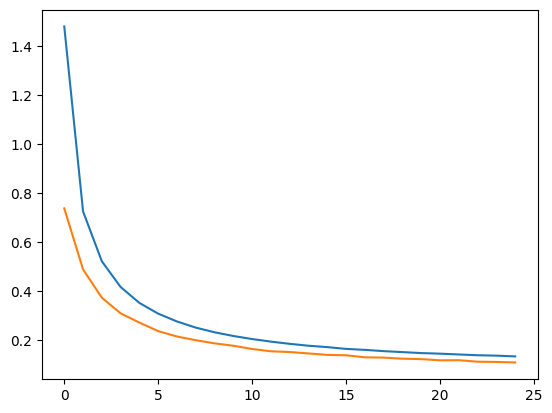

In [ ]:
train(train_dataloader, valid_dataloader,
      encoder, decoder, n_epochs=25,
      print_every=1, plot_every=1)

# Сохранение модели

In [ ]:
torch.save(encoder, '/content/drive/My Drive/encoder.pth')
torch.save(decoder, '/content/drive/My Drive/decoder.pth')

In [ ]:
encoder = torch.load('/content/drive/My Drive/encoder.pth')
decoder = torch.load('/content/drive/My Drive/decoder.pth')

# Перевод

In [ ]:
def translate(encoder, decoder, input, max_length=53):
    encoder.eval()
    decoder.eval()

    input_tensor = torch.tensor(input, dtype=torch.long, device=device).view(1, -1)
    tokens = []

    with torch.no_grad():
        context, _ = encoder(input_tensor)

        batch_size = context.size(0)
        next_token = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(1)

        state = None
        for _ in range(max_length):
            next_token, state = decoder(context, next_token, state)

            _, topi = next_token.topk(1)
            next_token = topi.squeeze(-1).detach()

            tokens.append(next_token)

            if (next_token.item() == 2):
                break

    return torch.cat(tokens, dim=1).tolist()[0]

## Метрики

Оценка BLEU на тестовом наборе

In [ ]:
references = []
translations = []

for i in range(len(X_test)):
    references.append(eng_vocab.vector2tokens(y_test[i]))
    sentence = translate(encoder, decoder, X_test[i])
    translations.append(eng_vocab.vector2tokens(sentence))

In [ ]:
bleu_references = [[ref] for ref in references]
bleu_score = corpus_bleu(bleu_references, translations)
print('BLEU Score: ', bleu_score)

BLEU Score:  0.5877358716615677


Близость эмбеддингов на тестовом наборе

In [ ]:
!pip install POT

In [ ]:
word2vec_model = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
def preprocess(model, sentense):
    return [word for word in sentense if word in model]

In [ ]:
total = 0
for i in range(10000):
    total += word2vec_model.wmdistance(preprocess(word2vec_model, references[i]),
                                       preprocess(word2vec_model, translations[i]))

print('WMD Similarity: ', total / len(references))

WMD Similarity:  0.1365988515142238


## Примеры переводов

На тренировочных данных

In [ ]:
for i in range(5):
    idx = random.randint(1, len(X_train))
    print('RUS: ', ' '.join(rus_vocab.vector2tokens(X_train[idx])))
    print('ENG: ', ' '.join(eng_vocab.vector2tokens(y_train[idx])))
    sentence = translate(encoder, decoder, X_train[idx])
    print('TRL: ', ' '.join(eng_vocab.vector2tokens(sentence)))
    print()

RUS:  я знаю , что она у тебя с собои .
ENG:  i know you have it with you .
TRL:  i know you have it with you .

RUS:  я заказал бокал вина .
ENG:  i ordered a glass of wine .
TRL:  i ordered a glass of wine .

RUS:  не думаю , что я знаю тома .
ENG:  i don t think i know tom .
TRL:  i don t think i know tom .

RUS:  я пообедал два часа назад .
ENG:  i ate lunch two hours ago .
TRL:  i ate lunch two hours ago .

RUS:  я рад , что ты это предложил .
ENG:  i m glad you suggested this .
TRL:  i m glad you suggested this .



На тестовых данных

In [ ]:
for i in range(5):
    idx = random.randint(1, len(X_test))
    print('RUS: ', ' '.join(rus_vocab.vector2tokens(X_test[idx])))
    print('ENG: ', ' '.join(eng_vocab.vector2tokens(y_test[idx])))
    sentence = translate(encoder, decoder, X_test[idx])
    print('TRL: ', ' '.join(eng_vocab.vector2tokens(sentence)))
    print()

RUS:  том не стал бы никого убивать .
ENG:  tom wouldn t murder anyone .
TRL:  tom wouldn t kill anyone .

RUS:  я в бостоне по делам .
ENG:  i m in boston on business .
TRL:  i m in boston on business .

RUS:  они сестры ?
ENG:  are they sisters ?
TRL:  are they sisters ?

RUS:  я никого не убивал .
ENG:  i didn t murder anyone .
TRL:  i didn t kill anyone .

RUS:  я знал , что том заплачет .
ENG:  i knew tom was going to cry .
TRL:  i knew that tom would cry .

